In [68]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from pytorchvideo.data.encoded_video import EncodedVideo
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm
import sys

%run objects
%run models

(1, 720, 1280)


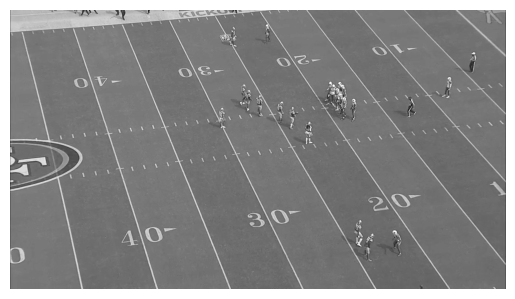

In [3]:
image=read_video(id = "58180_000986", view="Sideline", type="train", needed_frames=[8])

print(image.shape)
plt.imshow(image[0], cmap='gray')
plt.axis('off')  # Turn off axis
plt.show()

In [69]:
train_dataset = ContactDataset(os.getcwd() + "/nfl-player-contact-detection/train_labels.csv",
                               feature_size=256, num_back_forward_steps=1, pos_balance = 0.5,
                               skips=1, distance_cutoff=5, N=10)
train_dataset._cache_all_features()               

Data Sample Contains 3148 observations.
----Features being extracted for 10 plays and 3148 potential contacts-----


 30%|███       | 3/10 [08:28<19:47, 169.59s/it]


KeyboardInterrupt: 

In [5]:
train_dataset[2]

((tensor([[[117.0000, 117.0000, 116.0000,  ..., 116.0000, 117.0000, 117.0000],
           [117.0000, 117.0000, 117.0000,  ..., 117.0000, 117.0000, 117.0000],
           [117.0000, 117.0000, 117.0000,  ..., 116.0000, 117.0000, 116.0000],
           ...,
           [108.0000, 109.0000, 109.0000,  ..., 118.0000, 113.0000, 111.0000],
           [107.0000, 109.0000, 109.0000,  ..., 115.0000, 111.0000, 110.0000],
           [107.0000, 109.0000, 109.0000,  ..., 109.0000, 110.0000, 109.0000]],
  
          [[108.0000, 108.0000, 108.0000,  ..., 107.0000, 107.0000, 108.0000],
           [107.0000, 108.0000, 108.0000,  ..., 107.0000, 107.0000, 107.0000],
           [107.0000, 107.0000, 108.0000,  ..., 107.0000, 107.0000, 107.0000],
           ...,
           [120.0000, 219.0000, 254.0000,  ..., 231.0000, 219.0000, 233.0000],
           [122.0000, 224.0000, 255.0000,  ..., 242.0000, 217.0000, 223.0000],
           [115.0000, 216.0000, 255.0000,  ..., 221.0000, 189.0000, 204.0000]],
  
          [[

tensor([0.])


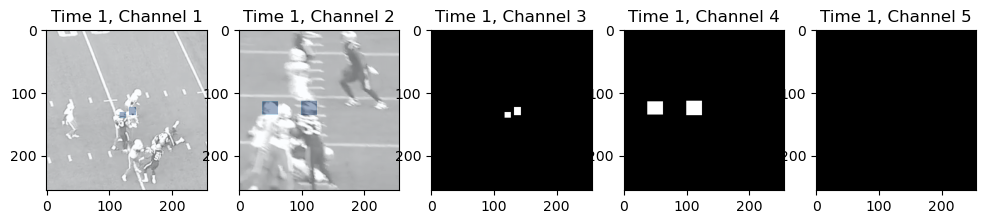

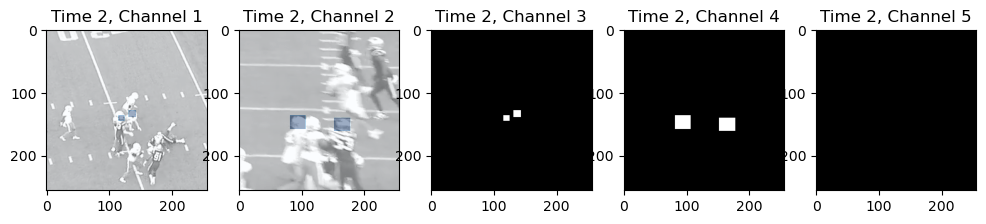

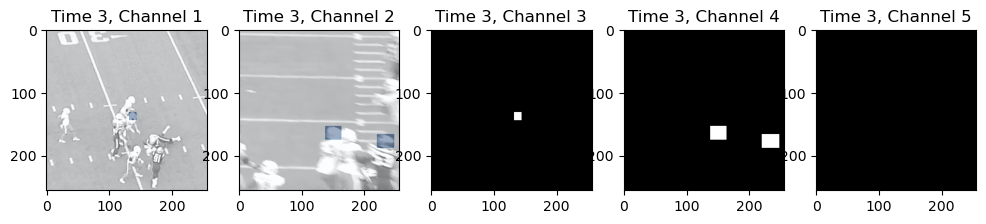

In [6]:
images=train_dataset[6]
j = 0
for image in images[0]:
    j+=1
    fig, axs = plt.subplots(1, 5, figsize=(12, 4)) 
    for i in range(5):
        channel = image[i, :, :]
        axs[i].imshow(channel, cmap='gray') 
        if i==0 or i==1:
            axs[i].imshow(image[i+2, :, :], alpha=0.4, cmap='Blues')  
        axs[i].set_title(f'Time {j}, Channel {i+1}')
print(images[1])

In [159]:
dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
for batch_idx, (features, labels) in enumerate(dataloader):
    print("loaded")

loaded


In [16]:
train_dataset[0][0][0].shape

torch.Size([5, 256, 256])

In [17]:
dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)

In [18]:
image_size = 256
input_size = 100  # Output size of the Encoder's fully connected layer
hidden_size = 64
num_layers = 2
dropout = 0.1
learning_rate = 0.001
num_epochs = 10

In [19]:
combined_model = ContactNet(image_size, input_size, hidden_size, num_layers, dropout)
device = torch.device('cpu')
combined_model.to(device)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = optim.Adam(combined_model.parameters(), lr=learning_rate)

In [20]:
num_epochs=3
for epoch in range(num_epochs):
    # Training loop
    combined_model.train()
    for batch_idx, (features, labels) in enumerate(dataloader):
        x1, x2, x3 = features
        # Forward pass
        outputs = combined_model(x1, x2, x3)

        loss = criterion(outputs.squeeze(), labels.squeeze().float())  # Compute loss
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(dataloader)}], Loss: {loss.item():.4f}')
        # Print loss
        if (batch_idx + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(dataloader)}], Loss: {loss.item():.4f}')

Epoch [1/3], Batch [1/1], Loss: 0.6931
Epoch [2/3], Batch [1/1], Loss: 0.6749
Epoch [3/3], Batch [1/1], Loss: 0.6460


In [30]:
this = combined_model.state_dict()
this['lstm.weight_ih_l0'].shape

torch.Size([256, 100])

In [66]:
%run objects

dataset = ContactDataset(os.getcwd() + "/nfl-player-contact-detection/test_labels.csv",
                      feature_size=image_size, num_back_forward_steps=1, 
                      skips=1, distance_cutoff=5, N=np.NaN, pos_balance=np.NaN)


dataset.record_df.loc[dataset.record_df.contact_id == "58172_003247_125_41937_45345"]

,Unnamed: 0,contact_id,contact,game_play,step,nfl_player_id_1,nfl_player_id_2,frame
2789,49335,58172_003247_125_41937_45345,NaN,58172_003247,125,41937,45345,1049


In [67]:
dataset[2789]

((tensor([[[128.0000, 128.0000, 127.0000,  ..., 134.0000, 134.0000, 134.0000],
           [128.0000, 127.0000, 127.0000,  ..., 135.0000, 135.0000, 134.0000],
           [128.0000, 127.0000, 127.0000,  ..., 135.0000, 135.0000, 134.0000],
           ...,
           [141.0000, 141.0000, 146.0000,  ..., 137.0000, 138.0000, 138.0000],
           [179.0000, 186.0000, 203.0000,  ..., 137.0000, 137.0000, 137.0000],
           [244.0000, 254.0000, 255.0000,  ..., 137.0000, 136.0000, 136.0000]],
  
          [[234.0000, 233.0000, 231.0000,  ...,  57.0000,  75.0000, 102.0000],
           [232.0000, 230.0000, 230.0000,  ...,  87.0000,  86.0000,  72.0000],
           [230.0000, 231.0000, 224.0000,  ...,  85.0000,  75.0000,  58.0000],
           ...,
           [134.0000, 131.0000, 142.0000,  ..., 109.0000,  47.0000,  16.0000],
           [144.0000, 165.0000, 173.0000,  ...,  54.0000,  73.0000,  78.0000],
           [152.0000, 158.0000, 131.0000,  ...,  45.0000, 130.0000, 129.0000]],
  
          [[

In [14]:
helmet = pd.read_csv("/Users/nickbachelder/Desktop/Personal Code/Kaggle/Contact/nfl-player-contact-detection/train_baseline_helmets.csv")
train_info = pd.read_csv("/Users/nickbachelder/Desktop/Personal Code/Kaggle/Contact/nfl-player-contact-detection/train_labels.csv")
tracking = pd.read_csv("/Users/nickbachelder/Desktop/Personal Code/Kaggle/Contact/nfl-player-contact-detection/train_player_tracking.csv")
train_info['frame'] = list(map(step_to_frame, train_info.step))

In [85]:
train_info.loc[train_info.contact==1]

,contact_id,game_play,datetime,step,nfl_player_id_1,nfl_player_id_2,contact,frame
809,58168_003392_3_41944_42565,58168_003392,2020-09-11T03:01:48.400Z,3,41944,42565,1,317
1062,58168_003392_4_41944_42565,58168_003392,2020-09-11T03:01:48.500Z,4,41944,42565,1,323
1163,58168_003392_4_37084_38567,58168_003392,2020-09-11T03:01:48.500Z,4,37084,38567,1,323
1289,58168_003392_5_43854_46445,58168_003392,2020-09-11T03:01:48.600Z,5,43854,46445,1,329
1315,58168_003392_5_41944_42565,58168_003392,2020-09-11T03:01:48.600Z,5,41944,42565,1,329
...,...,...,...,...,...,...,...,...
4720589,58582_003121_87_39971_G,58582_003121,2021-10-12T02:42:28.700Z,87,39971,G,1,821
4720842,58582_003121_88_39971_G,58582_003121,2021-10-12T02:42:28.800Z,88,39971,G,1,827
4721095,58582_003121_89_39971_G,58582_003121,2021-10-12T02:42:28.900Z,89,39971,G,1,833
4721348,58582_003121_90_39971_G,58582_003121,2021-10-12T02:42:29.000Z,90,39971,G,1,839


In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from pytorchvideo.data.encoded_video import EncodedVideo
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm
from objects import step_to_frame, create_boxes_dict, ContactDataset
from models import Encoder, LSTMModel, ContactNet
import torch
import torch.nn as nn
import torch.nn.functional as F

if torch.cuda.is_available():
    device = torch.device("cuda")  # Use GPU
    print("CUDA is available! Using GPU.")
else:
    device = torch.device("cpu")  # Use CPU
    print("CUDA is not available. Using CPU.")

print("---Loading Train Dataloader----")
dataset = ContactDataset(os.getcwd() + "/nfl-player-contact-detection/train_labels.csv",
                      ground=False, feature_size=256, num_back_forward_steps=1, skips=1, distance_cutoff=5, num_per_classification=10)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

image_size = 128
input_size = 100  # Output size of the Encoder's fully connected layer
hidden_size = 64
num_layers = 2
dropout = 0.1
learning_rate = 0.001
num_epochs = 10

print("---Initializing Model----")
combined_model = ContactNet(image_size, input_size, hidden_size, num_layers, dropout)
combined_model.to(device)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = optim.Adam(combined_model.parameters(), lr=learning_rate)


print("---Training----")
for epoch in range(num_epochs):
    # Training loop
    combined_model.train()
    print(f"---Epoch {epoch}----")
    for batch_idx, (features, labels) in enumerate(dataloader):
        print(f"Batch {batch_idx}")
        x1, x2, x3, x4, x5 = features
        x1, x2, x3, x4, x5, labels = x1.to(device), x2.to(device), x3.to(device), x4.to(device), x5.to(device), labels.to(device)
        # Forward pass
        outputs = combined_model(x1, x2, x3, x4, x5)
        loss = criterion(outputs.squeeze(), labels.float())  # Compute loss
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print loss
        if (batch_idx + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(dataloader)}], Loss: {loss.item():.4f}')

/Users/nickbachelder/opt/anaconda3/envs/data-science/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA is not available. Using CPU.
---Loading Train Dataloader----
Data Sample Contains 20 observations.
---Initializing Model----
---Training----
---Epoch 0----
Batch 0


ValueError: not enough values to unpack (expected 5, got 3)

In [87]:
def read_video(id, view, type, backround_removal=False):
    """Reads video to numpy array using Open-CV"""
    if backround_removal:
        filepath = f"nfl-player-contact-detection/{type}/backround_removal/{id}_{view}.mp4"
    else:
        filepath = f"nfl-player-contact-detection/{type}/{id}_{view}.mp4"
    # Open the video file
    cap = cv2.VideoCapture(filepath)
    
    # Get video properties
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    
    # Initialize an empty numpy array to store the frames
    video_array = np.empty((num_frames, 3, height, width), dtype=np.uint8)
    
    # Loop through each frame and store it in the numpy array
    for i in range(num_frames):
        ret, frame = cap.read()
        if not ret:
            break
        video_array[i] = frame.transpose(2, 0, 1)
        
    # Release the video object
    cap.release()
    return video_array

In [ ]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
import torch
import numpy as np
from PIL import Image
import requests

image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")

In [88]:
image=read_video(id = "58168_003392", view="Sideline", type="train", backround_removal=False)[0]
image.shape

(3, 720, 1280)

In [106]:

# prepare image for the model
inputs = image_processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.shape[1:],
    mode="bicubic",
    align_corners=False,
).squeeze()

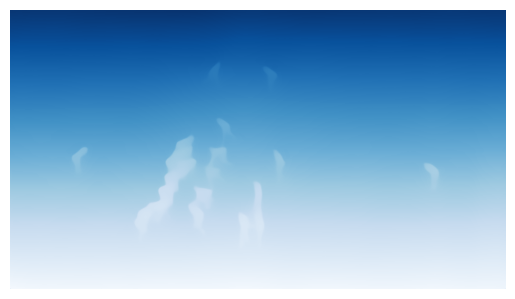

In [115]:
plt.imshow(prediction, cmap='Blues_r')
plt.axis('off')  # Turn off axis
plt.show()

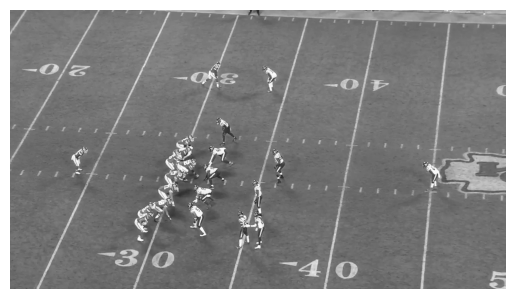

: 

In [9]:
resnet= models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

In [11]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [2]:
tracking_df = pd.read_csv(os.getcwd() + "/nfl-player-contact-detection/train_player_tracking.csv")
label_df = pd.read_csv(os.getcwd() + "/nfl-player-contact-detection/train_labels.csv")

In [3]:
distances_df = label_df[['game_play', 'step', 'nfl_player_id_1', 'nfl_player_id_2']].drop_duplicates()
num_back_forward_steps=2
skips=1
needed_steps_added = np.arange(-num_back_forward_steps*skips, num_back_forward_steps*skips+1, skips).tolist()

updated_distances_df = [distances_df]
for added_step in needed_steps_added:
    append_df = distances_df.copy()
    append_df['step'] = append_df['step']+added_step
    updated_distances_df.append(append_df)
updated_distances_df=pd.concat(updated_distances_df, axis = 0)
updated_distances_df

merge_p2 = (
            updated_distances_df.astype(str).merge(
                tracking_df.rename(
                    {"nfl_player_id": "nfl_player_id_1", "x_position": "x_position_1", "y_position": "y_position_1"},
                    axis=1,
                ).astype(str),
                on=["game_play", "nfl_player_id_1", "step"],
                how="left",
            )
            .merge(
                tracking_df.rename(
                    {"nfl_player_id": "nfl_player_id_2", "x_position": "x_position_2", "y_position": "y_position_2"},
                    axis=1,
                ).astype(str),
                on=["game_play", "nfl_player_id_2", "step"],
                how="left",
            )
        )
merge_p2

KeyboardInterrupt: 

In [125]:
base = "/Users/nickbachelder/Desktop/Personal Code/Kaggle/Contact/nfl-player-contact-detection/train/58580_001136_Sideline.mp4".split("/")[-1]
game_play = base.split("_")[0]+ "_"+base.split("_")[1]
game_play

'58580_001136'

In [130]:
from itertools import chain



{-9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}